# Data Exploration FAO Locust Hub - Swarm dataset

You can find the data here: https://locust-hub-hqfao.hub.arcgis.com/datasets/swarms-1/data?geometry=30.884%2C0.881%2C41.365%2C2.802&showData=true

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import imageio

In [2]:
df = pd.read_csv('data/Swarms.csv')
df.shape

(31592, 152)

In [3]:
df.head(2)

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,...,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT
0,-15.131944,17.870278,1,1985/11/30 00:00:00,12:00,1985/11/30 00:00:00,12:00,No,Late,,...,,0.0,,0,0,0,0,0,0,Swarm
1,-15.400278,18.030833,2,1985/11/26 00:00:00,12:00,1985/11/26 00:00:00,12:00,No,Late,,...,,0.0,,0,0,0,0,0,0,Swarm


In [4]:
df.tail(2)

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,...,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT
31590,43.429722,9.670000,43457,2020/11/05 23:00:00,09:47,2020/11/05 23:00:00,09:47,No,Early,Helicopter Control,...,,250.10001,ha,0,0,1,0,0,0,Swarm
31591,43.611111,9.870556,43458,2020/11/05 23:00:00,09:51,2020/11/05 23:00:00,09:51,No,Early,Helicopter Control,...,,125.00000,ha,0,0,1,0,0,0,Swarm


## 1. Cleaning

### Date & time

Merge date & time columns and convert them into datetime format

In [5]:
# Only keep the date of the start date column
df['STARTDATE'] = pd.to_datetime(df['STARTDATE']).dt.date.astype('str')
# Merge date and time columns into a datetime column
df['datetime_start'] = pd.to_datetime(df['STARTDATE'] + ' ' + df['TmSTARTDAT'])
# Same for finish date & time columns
df['FINISHDATE'] = pd.to_datetime(df['FINISHDATE']).dt.date.astype('str')
df['datetime_finish'] = pd.to_datetime(df['FINISHDATE'] + ' ' + df['TmFINISHDA'])
# Drop superfluous date and time columns
df = df.drop(['STARTDATE', 'TmSTARTDAT', 'FINISHDATE', 'TmFINISHDA'], axis=1)

Let's only keep the observations from 2020 (the data goes way back)

In [6]:
df = df[df['datetime_start'].dt.year == 2020]

As we can see there is no entry where datetime_start and datetime_finish differ...

In [7]:
df[df['datetime_start'] != df['datetime_finish']]

,X,Y,OBJECTID,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,...,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,datetime_start,datetime_finish


... so let's remove & rename the columns accordingly

In [8]:
df = df.drop(['datetime_finish'], axis=1)
df = df.rename(columns={'datetime_start' : 'datetime'})

In [9]:
df = df.sort_values('datetime')

### Location

For now let's only consider observations from Kenya

In [10]:
df = df[df['COUNTRYID'] == 'KE']

Next, we can take advantage of the X Y coordinates in the dataframe to convert it into a geodataframe 

In [11]:
# convert to geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))
# change projection to fit with background map
gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

## 2. Data exploration
The legend for the data comes in a seperately downloadable excel sheet. Based on that, I have tried to select the potentially relevant columns and explored them below.

### Location name
Text field for the location of the sighting

In [12]:
len(gdf.LOCNAME.unique())

1089

In [13]:
gdf.LOCNAME.value_counts()

Samburu                 147
Marsabit county kala    135
Turkana County,Lowoi     74
Marsabit                 47
Isiolo County            45
                       ... 
Rikiau area               1
Shambani                  1
Mpala ranch               1
Naisunyai                 1
Nyaituga                  1
Name: LOCNAME, Length: 1089, dtype: int64

There are over 1000 location names in the column and the entries look quite dirty, so this column might be of limited use.

### Location & report reliability
Columns indicating whether the location was recorded accurately and the report is reliable (unclear what this assessment is based on)

In [14]:
gdf.LOCRELIAB.value_counts()

Exact    2168
Name: LOCRELIAB, dtype: int64

In [15]:
gdf.REPRELIAB.value_counts()

1    2167
2       1
Name: REPRELIAB, dtype: int64

All of the registered locations in Kenya 2020 are considered reliable. 

Only 1 of 2168 reports is considered dubious (the legend says: dubious (0), reliable (1), but this is probably an oversight and the 2 is code for dubious)

### Locust presence
Whether locusts were present / observed or not

In [16]:
gdf.LOCPRESENT.value_counts()

1    2166
2       2
Name: LOCPRESENT, dtype: int64

There are only 2 entries were no locusts were reported.

### Comments
Text field for comments on the observation

In [17]:
gdf.ACOMMENT.value_counts()

                        731
(eL3M)                  539
eL3M                    144
they are grassing (e     39
(EarthRanger)            27
                       ... 
a swarm heading pass      1
To be sprayed once t      1
urgent Control neede      1
all locust have died      1
still settling on ac      1
Name: ACOMMENT, Length: 361, dtype: int64

A lot of empty observations. Nevertheless, the comments could be used to single out some observations of particular interest. 

### Gregarious hopper density / count / maturity / colour / area
Specific attributes of the nature sighted locust swarm. Below only a selection of columns as most of them have not data.

In [18]:
# Low gregarious adult density (0-no, 1-yes)
gdf.GADDENLOW.value_counts()

0    2168
Name: GADDENLOW, dtype: int64

In [19]:
# Medium gregarious adult density (0-no, 1-yes)
gdf.GADDENMED.value_counts()

0    2155
1      13
Name: GADDENMED, dtype: int64

In [20]:
# High gregarious adult density (0-no, 1-yes)
gdf.GADDENHI.value_counts()

0    2126
1      42
Name: GADDENHI, dtype: int64

In [21]:
# gregarious adult minimum area (km2)
gdf.GADMINASKM.value_counts()

0.0     2160
1.0        1
3.0        1
25.0       1
80.0       1
30.0       1
14.0       1
8.0        1
24.0       1
Name: GADMINASKM, dtype: int64

In [22]:
# gregarious adult maximum area (km2)
gdf.GADMAXASKM.value_counts()

0.0      2160
30.0        2
2.0         1
5.0         1
100.0       1
14.0        1
8.0         1
24.0        1
Name: GADMAXASKM, dtype: int64

Very few limited information in these columns. One could use it to identify some examples of some large / dense locust swarms, but most likely incomplete.

### Location

Let's map the datapoints to get a better feeling for the data

In [23]:
# drop observations that were unreliable or where no locusts were sighted
gdf = gdf[(gdf.LOCPRESENT == 1) & (gdf.REPRELIAB == 1)]

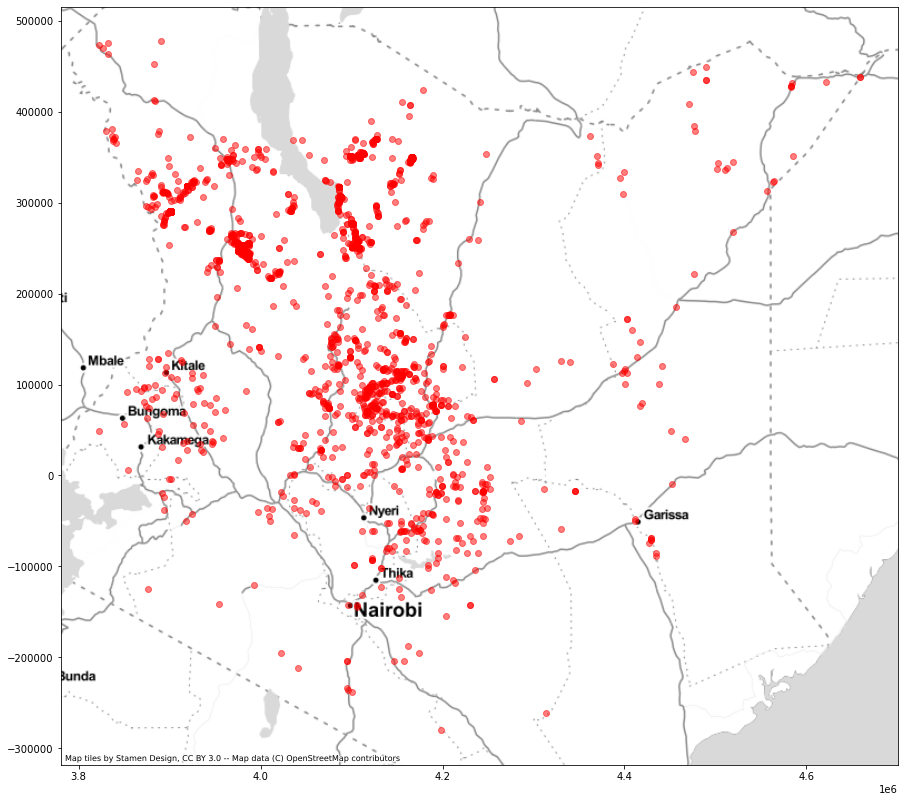

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, alpha=0.5, linewidth=1, color='red', zorder=2)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.show()

### Observations by month

In [25]:
# set index to month (number)
gdf = gdf.set_index(gdf.datetime.dt.month)

<AxesSubplot:xlabel='datetime'>

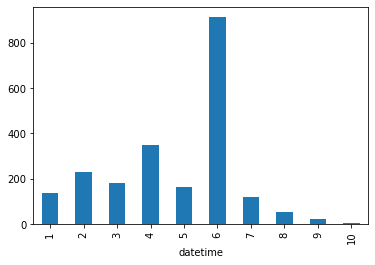

In [26]:
gdf.groupby(gdf.index)['X'].count().plot(kind='bar')

By far the most observations are from June, with relatively few entries August onwards.



## 3. Animated map (GIF)
Let's create an animated map to look at spatio-temporal aspects at once

In [27]:
# set index to month name
gdf = gdf.set_index(gdf.datetime.dt.month_name())

In [28]:
def create_maps(path_images):
    '''Creates a map with positions of locust reports per week
    and saves it to indicated filepath
    ------------
    Parameters:
    - path_images: string (filepath)
    ------------
    Output: None
    '''
    for i in gdf.index.unique():
        fig, ax = plt.subplots(figsize=(15, 15))

        ax.set_aspect(aspect='equal')
        ax.set_axis_off()
        ax.set_ylim([-300_000, 500_000])
        ax.set_xlim([3_800_000, 4_700_000])

        gdf.loc[i].plot(ax=ax, alpha=0.5, linewidth=1, color='red', zorder=2)
        ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

        fig.text(0.2, 0.5, i, fontsize=100, color='gray', alpha=0.2, weight='bold')
        
        plt.savefig(f'{path_images}/{i}.png')

        print(i)

January
February
March
April
May
June
July
August
September
October


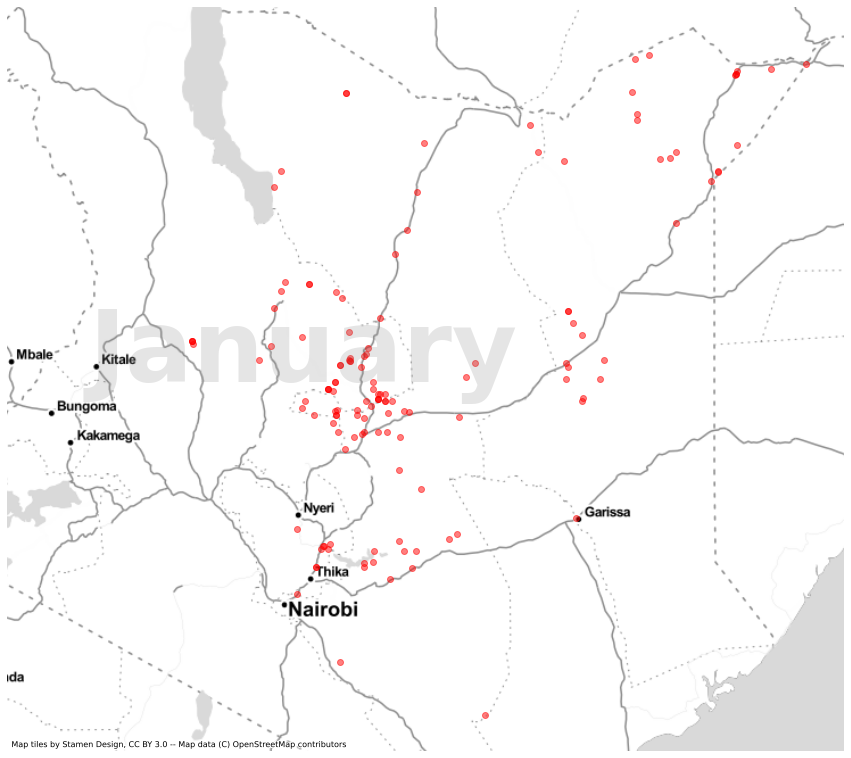

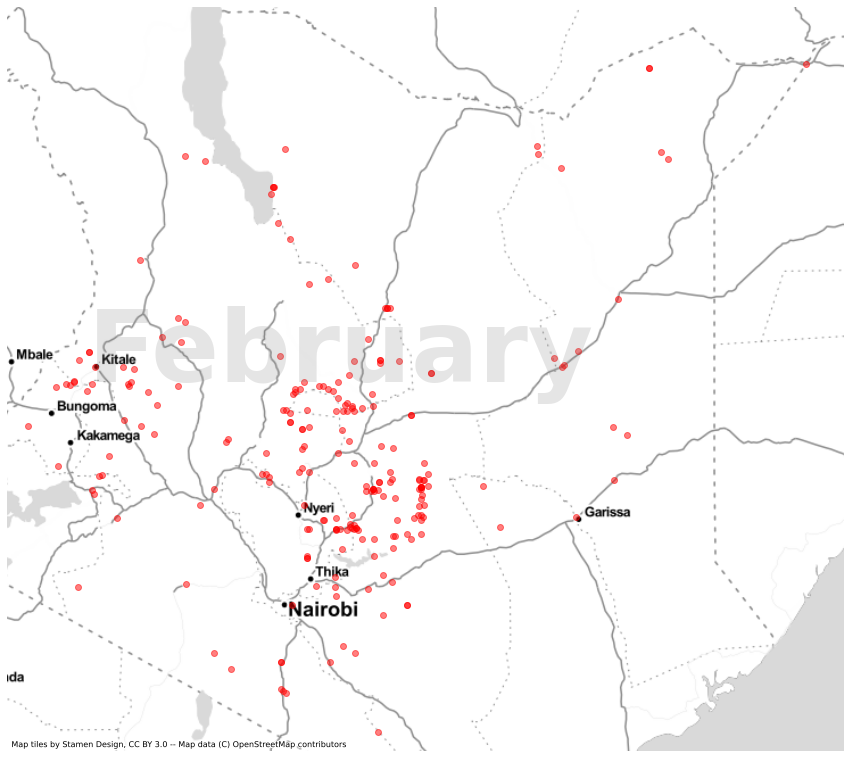

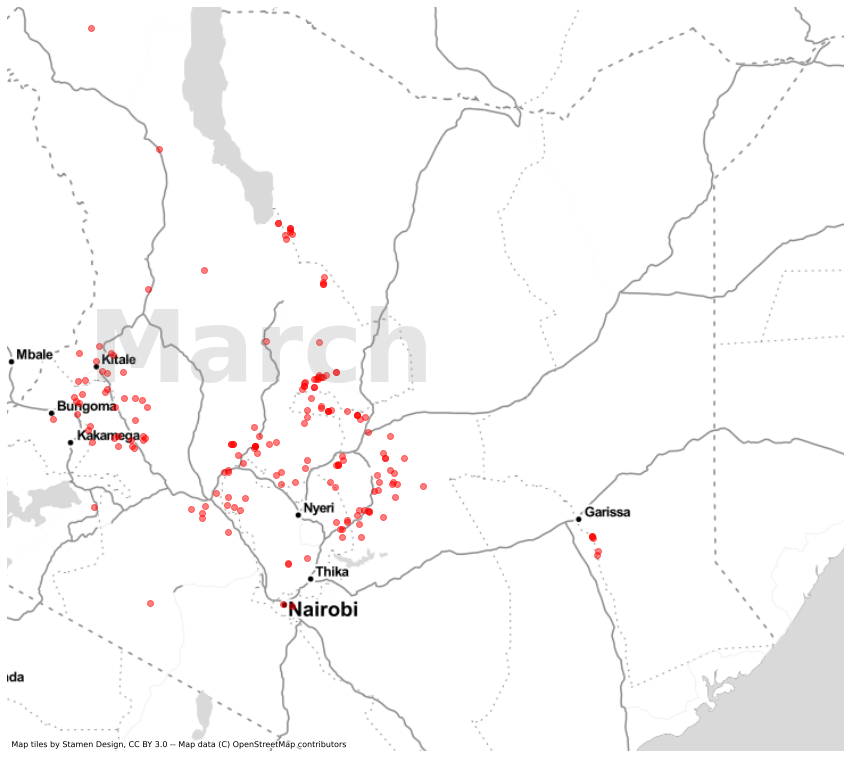

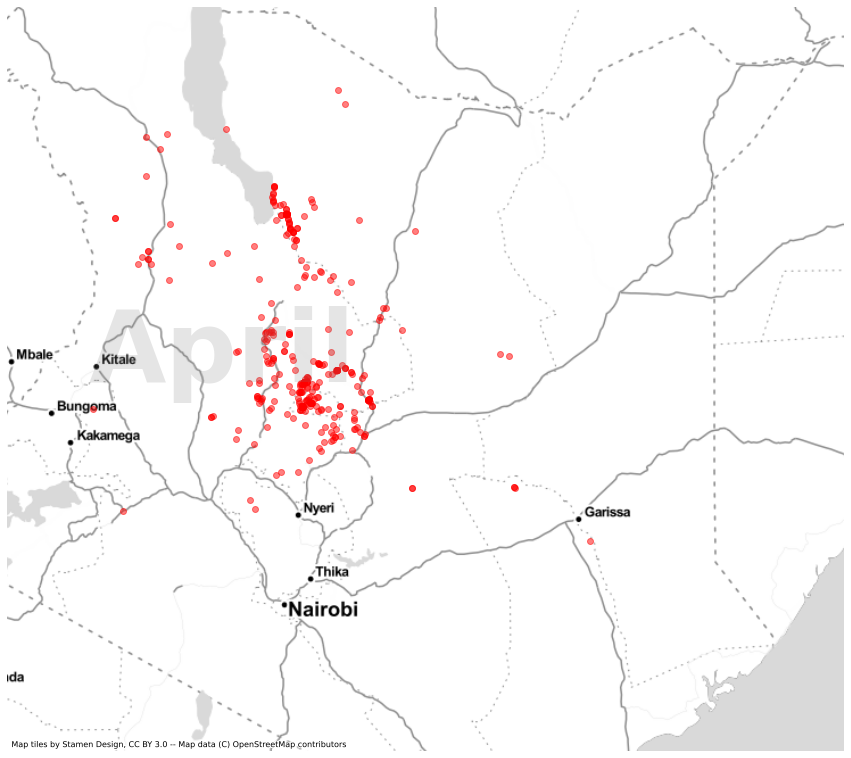

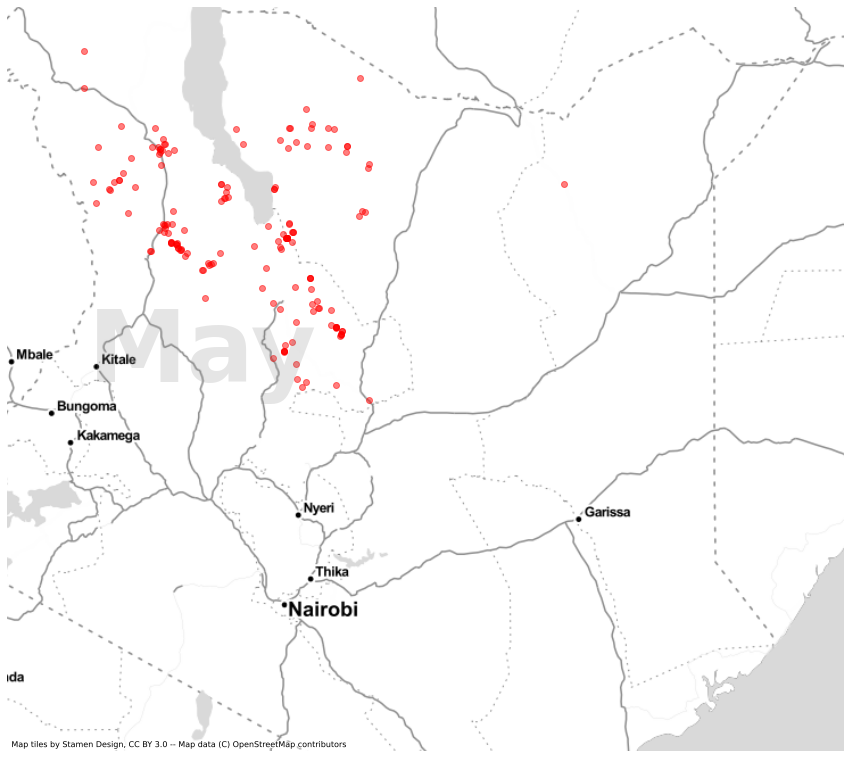

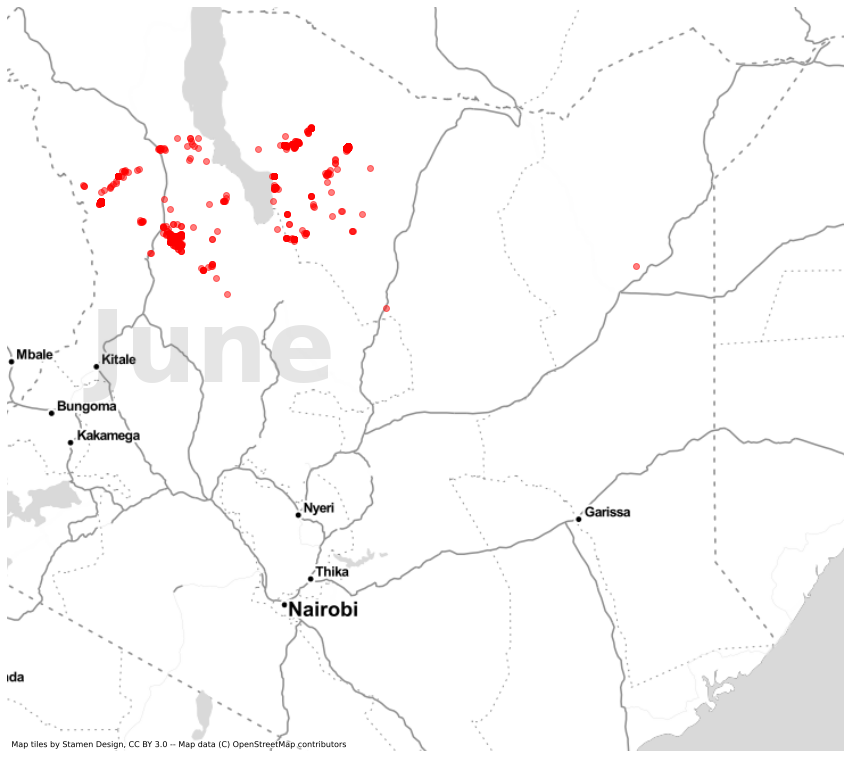

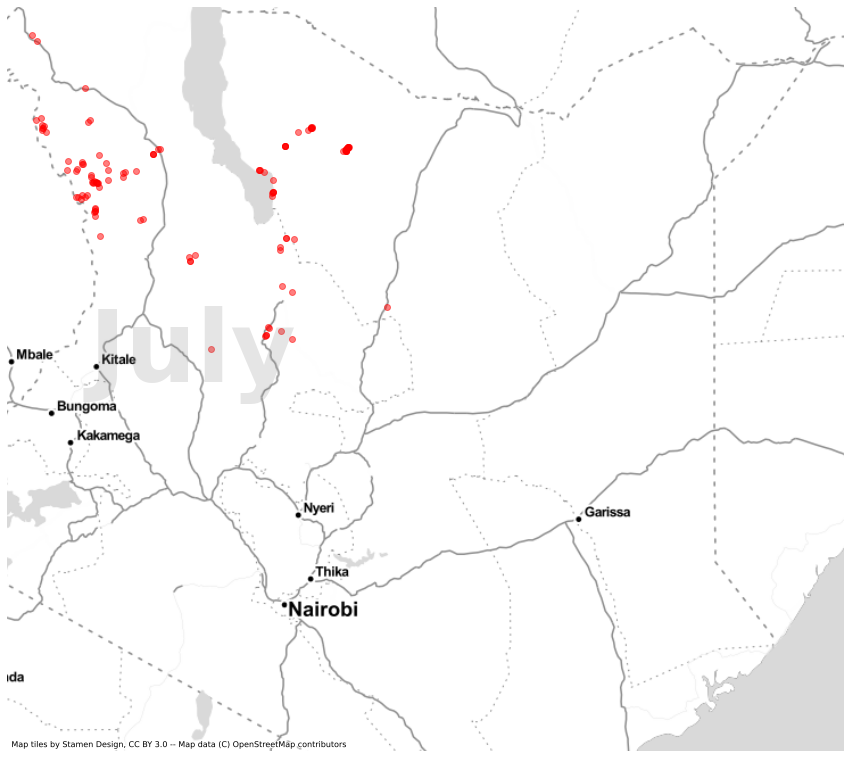

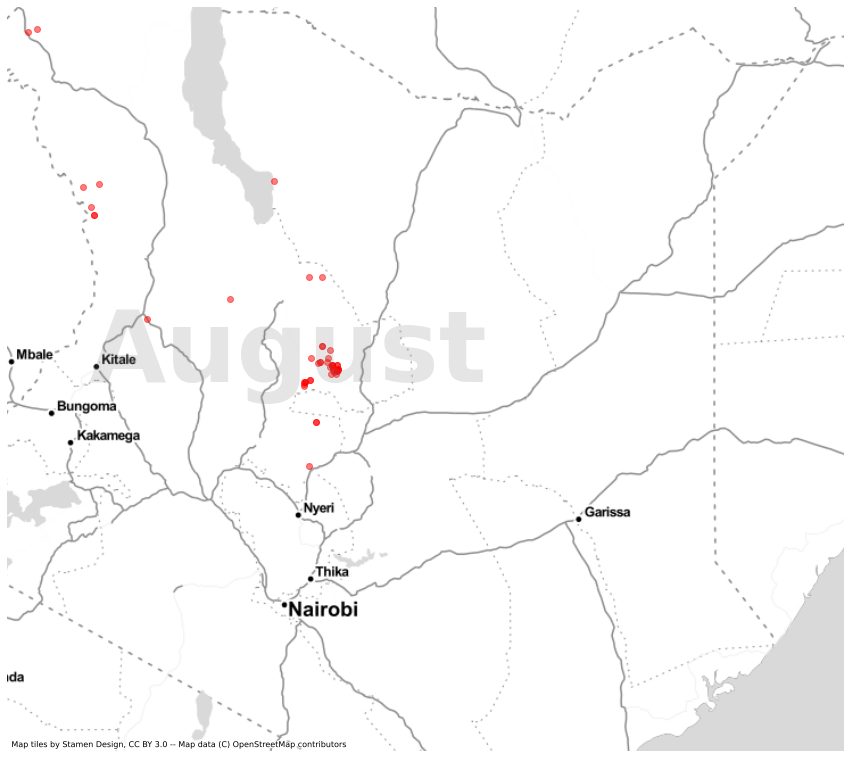

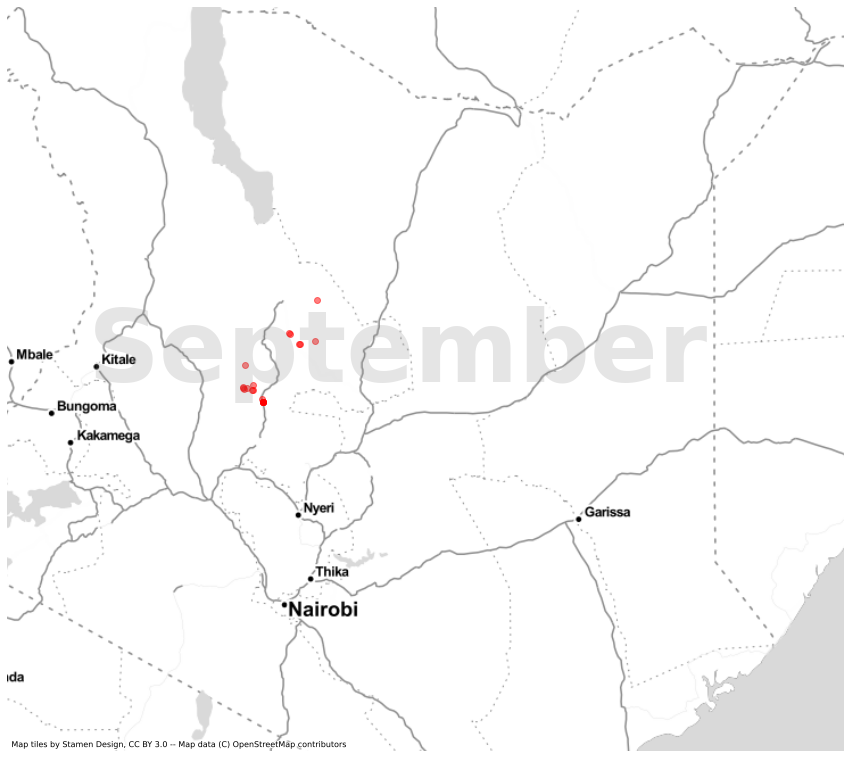

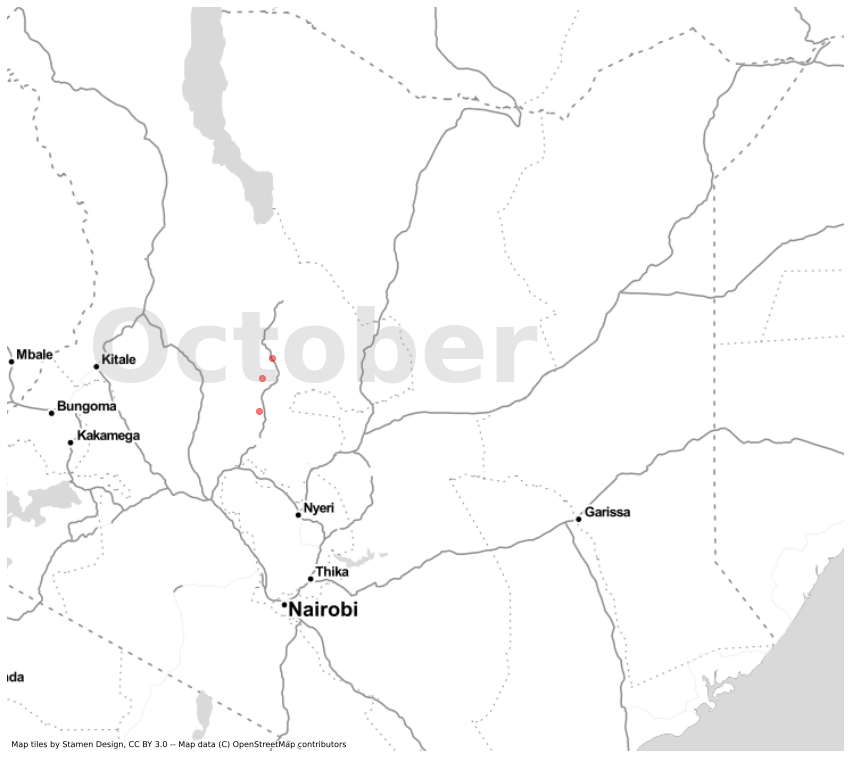

In [29]:
create_maps('gif/pictures')

In [30]:
def create_gif(path_images, path_gif):
    '''Creates gif from maps
    ------------
    Parameters:
    - path_images: string (filepath)
    - path_gif: string (filepath & name)
    ------------
    Output: None
    '''
    list_of_images = []

    for i in gdf.index.unique():
        img = imageio.imread(f'{path_images}/{i}.png')
        list_of_images.append(img)

    imageio.mimsave(path_gif, list_of_images, fps=2)

In [33]:
create_gif('gif/pictures', 'gif/locust.gif')

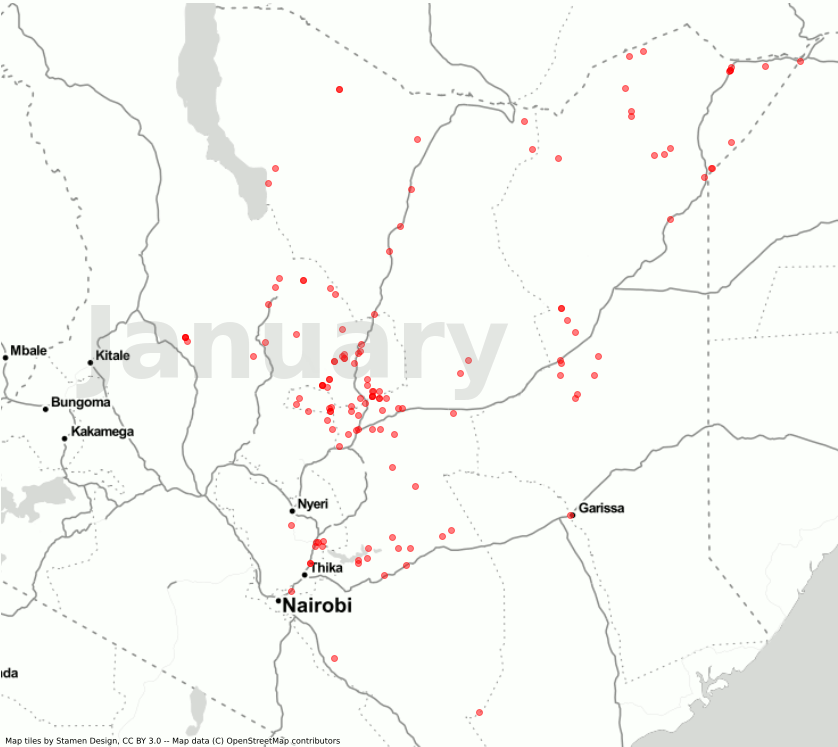